In [7]:
import numpy as np
import gym
import tensorflow as tf
import matplotlib

%matplotlib inline

import matplotlib.pyplot as plt

In [2]:
env = gym.make('Pong-v0')

[2017-07-04 19:47:31,529] Making new env: Pong-v0


In [4]:
print(env.action_space)
print(env.observation_space)

Discrete(6)
Box(210, 160, 3)


In [5]:
from gym import envs
print(len(envs.registry.all()))

777


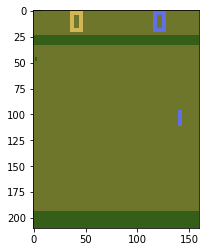

In [8]:
plt.imshow(env.reset())

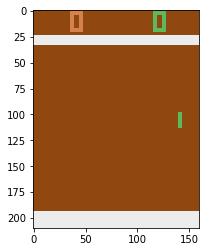

In [25]:
observation, reward, done, info = env.step(3)

plt.imshow(observation)

In [ ]:
# hyperparameters
n_obs = 80 * 80           # dimensionality of observations
h = 200                   # number of hidden layer neurons
n_actions = 3             # number of available actions
learning_rate = 1e-3
gamma = .99               # discount factor for reward
decay = 0.99              # decay rate for RMSProp gradients
save_path='models-livecoding/pong.ckpt'

# gamespace 
env = gym.make("Pong-v0") # environment info
observation = env.reset()
prev_x = None
xs,rs,ys = [],[],[]
running_reward = None
reward_sum = 0
episode_number = 0

def tf_discount_rewards(tf_r): #tf_r ~ [game_steps,1]
    pass

def tf_policy_forward(x): #x ~ [1,D]
    pass

# downsampling
def prepro(I):
    """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
    I = I[35:195] # crop
    I = I[::2,::2,0] # downsample by factor of 2
    I[I == 144] = 0  # erase background (background type 1)
    I[I == 109] = 0  # erase background (background type 2)
    I[I != 0] = 1    # everything else (paddles, ball) just set to 1
    return I.astype(np.float).ravel()

# tf placeholders
tf_x = tf.placeholder(dtype=tf.float32, shape=[None, n_obs],name="tf_x")
tf_y = tf.placeholder(dtype=tf.float32, shape=[None, n_actions],name="tf_y")
tf_epr = tf.placeholder(dtype=tf.float32, shape=[None,1], name="tf_epr")

# tf reward processing (need tf_discounted_epr for policy gradient wizardry)
tf_discounted_epr = tf_discount_rewards(tf_epr)
tf_mean, tf_variance= tf.nn.moments(tf_discounted_epr, [0], shift=None, name="reward_moments")
tf_discounted_epr -= tf_mean
tf_discounted_epr /= tf.sqrt(tf_variance + 1e-6)

# tf optimizer op
tf_aprob = tf_policy_forward(tf_x)

# TODO: compute loss

# tf graph initialization
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

# try load saved model
saver = tf.train.Saver(tf.all_variables())
load_was_success = True # yes, I'm being optimistic
try:
    save_dir = '/'.join(save_path.split('/')[:-1])
    ckpt = tf.train.get_checkpoint_state(save_dir)
    load_path = ckpt.model_checkpoint_path
    saver.restore(sess, load_path)
except:
    print("no saved model to load. starting new session")
    load_was_success = False
else:
    print("loaded model: {}".format(load_path))
    saver = tf.train.Saver(tf.all_variables())
    episode_number = int(load_path.split('-')[-1])


# training loop
while True:
#     if True: env.render()

    # preprocess the observation, set input to network to be difference image
    cur_x = prepro(observation)
    x = cur_x - prev_x if prev_x is not None else np.zeros(n_obs)
    prev_x = cur_x

    # stochastically sample a policy from the network
    feed = {tf_x: np.reshape(x, (1,-1))}
    aprob = sess.run(tf_aprob,feed) ; aprob = aprob[0,:]
    action = np.random.choice(n_actions, p=aprob)
    label = np.zeros_like(aprob) ; label[action] = 1

    # step the environment and get new measurements
    observation, reward, done, info = env.step(action+1)
    reward_sum += reward
    
    # record game history
    xs.append(x) ; ys.append(label) ; rs.append(reward)
    
    if done:
        # update running reward
        running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
        
        # parameter update
        feed = {tf_x: np.vstack(xs), tf_epr: np.vstack(rs), tf_y: np.vstack(ys)}
        _ = sess.run(train_op,feed)
        
        # print progress console
        if episode_number % 10 == 0:
            print('ep {}: reward: {}, mean reward: {:3f}'.format(episode_number, reward_sum, running_reward))
        else:
            print('\tep {}: reward: {}'.format(episode_number, reward_sum))
        
        # bookkeeping
        xs,rs,ys = [],[],[] # reset game history
        episode_number += 1 # the Next Episode
        observation = env.reset() # reset env
        reward_sum = 0
        if episode_number % 50 == 0:
            saver.save(sess, save_path, global_step=episode_number)
            print("SAVED MODEL #{}".format(episode_number))